# Statistical Analyis of Bay Area Bike Share Data

> From our initial Visual Exploratory Data Analysis on the Bay Area BIke Share dataset, we inferred that the vast majority of the trips are taken by cummuters, who are subscribers.
>
> Lets now see if we can show a statistical significance or coorelation between stations and trips.
>
>
>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sns.set()

## Load Trip Data

In [2]:
print('Loading Trip Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_trip_data.csv'
    
    # glob all files
    file_list = glob(file_path_slug)
    
    trip_import = pd.DataFrame()
    
    counter = 1
    chunks = []
    
    # load data from each file
    for file in file_list:
        
        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
            
            # set chunk index column to 'Trip ID'
            chunk = chunk.set_index('Trip ID')
            
            # define Columns
            chunk.columns = ['Duration', 'Start Date', 'Start Station', 'Start Terminal', 'End Date', 
                             'End Station', 'End Terminal', 'Bike #', 'Subscriber Type', 'Zip Code']
            
            # append chunk to chunks list
            chunks.append(chunk)
        
        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1
    
    # concat chunks
    trip_import = pd.concat(chunks)
    
    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')


Loading Trip Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


In [3]:
trip = trip_import.copy()
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 10 columns):
Duration           983648 non-null int64
Start Date         983648 non-null object
Start Station      983648 non-null object
Start Terminal     983648 non-null int64
End Date           983648 non-null object
End Station        983648 non-null object
End Terminal       983648 non-null int64
Bike #             983648 non-null int64
Subscriber Type    983648 non-null object
Zip Code           976838 non-null object
dtypes: int64(4), object(6)
memory usage: 82.6+ MB


### Clean Trip info

In [4]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

In [5]:
print('Trip Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in trip.columns:
    new_cols.append(col.replace(' ', '_').lower())
trip.columns = new_cols

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
trip = trip[important_cols]

# create duration minutes column
print('\tcreating a duration_minutes column')
trip['duration_minutes'] = trip['duration'] / 60.0

# convert end and start dates to datetime objects
print('\tconverting end and start dates to datetime objects')
trip['start_date'] = pd.to_datetime(trip['start_date'], format="%m/%d/%Y %H:%M")
trip['end_date']   = pd.to_datetime(trip['end_date'],   format="%m/%d/%Y %H:%M")

# create a start and end hour trip column
print('\tcreating start_hour and end_hour columns')
trip['trip_date']  = trip['start_date'].dt.date
trip['start_hour'] = trip['start_date'].dt.hour
trip['end_hour']   = trip['end_date'].dt.hour



# convert and clean zipcodes
print('\tcleaning zipcodes')
trip['zip_code'] = trip['zip_code'].astype(str)
trip.zip_code = trip.zip_code.apply(clean_zipcode)
trip['zip_code'] = pd.to_numeric(trip['zip_code'], errors='coerce')


print('Trip Data Cleanup complete')
trip_clean = trip.copy()

Trip Data Cleanup Started...
	cleaning column names
	subsetting to useful columns
	creating a duration_minutes column
	converting end and start dates to datetime objects
	creating start_hour and end_hour columns
	cleaning zipcodes
Trip Data Cleanup complete


### Prune Trip Data to exlude outliers previously discovered, and only San Francisco Trips

In [6]:
# our data set show duration in seconds, here are some handy conversions
second = 1
minute = second * 60
hour = minute * 60
day = hour * 24

# station ID numbers that are in San Francisco
sf_stations = [ 39,41,42,45,46,47,48,49,50,51,54,55,56,57,58,59,60,61,62,63,
                64,65,66,67,68,69,70,71,72,73,74,75,76,77,82,90,91]

pruning data to trips no more than 35 minutes long...
	pruned data set 'trips' consists of 857505 entries


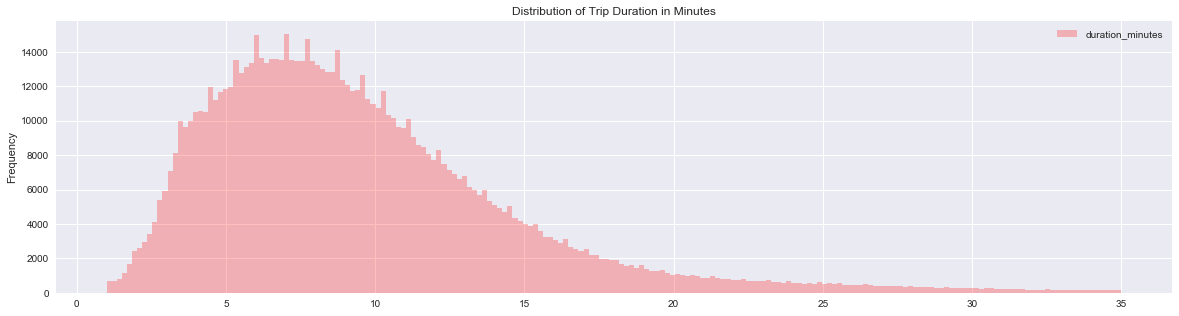

In [7]:
# prune data to exclude trips longer than 35 minutes
print('pruning data to trips no more than 35 minutes long...')
trips_sf = trip[trip['duration'] <= 35 * minute].copy()

#prune each data set to include only trips where both start and end terminals are inside San Francisco
trips_sf = trips_sf.loc[trips_sf['start_terminal'].isin(sf_stations)]
trips_sf = trips_sf.loc[trips_sf['end_terminal'].isin(sf_stations)]

# Cleanup
trips_sf.sort_index(inplace=True)
print('\tpruned data set \'trips\' consists of %i entries' % len(trips_sf.index))

# plot histogram of trip duration
trips_sf['duration_minutes'].plot(kind='hist', color='r', alpha=0.25, bins=200, figsize=(20,5))
plt.title('Distribution of Trip Duration in Minutes')
plt.xlabel='Trip Duration (Minutes)'
plt.ylabel='Number of Trips'
plt.legend(loc='best')
plt.show()

In [8]:
trips_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857505 entries, 4069 to 1338408
Data columns (total 12 columns):
duration            857505 non-null int64
start_date          857505 non-null datetime64[ns]
start_terminal      857505 non-null int64
end_date            857505 non-null datetime64[ns]
end_terminal        857505 non-null int64
bike_#              857505 non-null int64
subscriber_type     857505 non-null object
zip_code            832895 non-null float64
duration_minutes    857505 non-null float64
trip_date           857505 non-null object
start_hour          857505 non-null int64
end_hour            857505 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 85.0+ MB


In [9]:
# look at unique values in each column
print('#' * 80)
print('#\tColumns and unique values')
# detail_cols = ['start_terminal', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code', 'start_date']
detail_cols = ['trip_date']
for col in detail_cols:
    print('Column : ' + col + '\t' + str(len(pd.unique(trips_sf[col]))))
    print(np.sort(pd.unique(trips_sf[col])))
    print()

################################################################################
#	Columns and unique values
Column : trip_date	1099
[datetime.date(2013, 8, 29) datetime.date(2013, 8, 30)
 datetime.date(2013, 8, 31) ..., datetime.date(2016, 8, 29)
 datetime.date(2016, 8, 30) datetime.date(2016, 8, 31)]



## Load Weather Data

In [10]:
print('Loading Weather Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_weather_data.csv'
    
    # glob all files
    file_list = glob(file_path_slug)
    
    weather_import = pd.DataFrame()
    
    counter = 1
    chunks = []
    
    # load data from each file
    for file in file_list:
        
        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
                        
            # define Columns
            chunk.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F', 
                             'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                             'Max_Sea_Level_Pressure_In', 'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In', 
                             'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles', 
                             'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH', 'Precipitation_In', 
                             'Cloud_Cover', 'Events', 'Wind_Dir_Degrees', 'zip']
            
            # set chunk index column to 'Date'
#             chunk = chunk.set_index('Date')

            # append chunk to chunks list
            chunks.append(chunk)
        
        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1
    
    # concat chunks
    weather_import = pd.concat(chunks)
    
    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')



Loading Weather Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


In [11]:
weather_data = weather_import.copy()
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5495 entries, 0 to 1824
Data columns (total 24 columns):
Date                          5495 non-null object
Max_Temperature_F             5491 non-null float64
Mean_Temperature_F            5491 non-null float64
Min_TemperatureF              5491 non-null float64
Max_Dew_Point_F               5441 non-null float64
MeanDew_Point_F               5441 non-null float64
Min_Dewpoint_F                5441 non-null float64
Max_Humidity                  5441 non-null float64
Mean_Humidity                 5441 non-null float64
Min_Humidity                  5441 non-null float64
Max_Sea_Level_Pressure_In     5494 non-null float64
Mean_Sea_Level_Pressure_In    5494 non-null float64
Min_Sea_Level_Pressure_In     5494 non-null float64
Max_Visibility_Miles          5473 non-null float64
Mean_Visibility_Miles         5473 non-null float64
Min_Visibility_Miles          5473 non-null float64
Max_Wind_Speed_MPH            5494 non-null float64
Mean_Wind_

### Clean Weather info

In [12]:
print('Weather Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in weather_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
weather_data.columns = new_cols
weather = weather_data.copy()

# convert end and start dates to datetime objects
print('\tconverting dates to datetime objects')
weather['date'] = pd.to_datetime(weather['date'], format="%m/%d/%Y")

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperaturef',
                  'max_dew_point_f', 'meandew_point_f', 'min_dewpoint_f',
                  'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
                  'precipitation_in', 'cloud_cover', 'events', 'zip']
weather = weather[important_cols]

# correct min_temperaturef column name to min_temperature_f
# weather['min_temperaturef'].rename('min_temperature_f')
weather.rename(columns={'min_temperaturef': 'min_temperature_f'}, inplace=True)

# cleanup and set date as index
weather.set_index('date', inplace=True)
weather.sort_index(inplace=True)

# cleanup precipitation data to be all float values
weather['precipitation_in'] = pd.to_numeric(weather['precipitation_in'], errors='coerce')

print('Weather Data Cleanup complete')

Weather Data Cleanup Started...
	cleaning column names
	converting dates to datetime objects
	subsetting to useful columns
Weather Data Cleanup complete


### Prune Weather Data to include only San Francisco Zip Code Data

In [13]:
# prune weather data to only San Francisco data
print('pruning weather data to only San Francisco data')
weather_sf = weather[weather['zip'] == 94107].copy()

pruning weather data to only San Francisco data


In [14]:
weather_sf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1099 entries, 2013-08-29 to 2016-08-31
Data columns (total 13 columns):
max_temperature_f      1099 non-null float64
mean_temperature_f     1099 non-null float64
min_temperature_f      1099 non-null float64
max_dew_point_f        1099 non-null float64
meandew_point_f        1099 non-null float64
min_dewpoint_f         1099 non-null float64
max_wind_speed_mph     1099 non-null float64
mean_wind_speed_mph    1099 non-null float64
max_gust_speed_mph     1083 non-null float64
precipitation_in       980 non-null float64
cloud_cover            1099 non-null float64
events                 256 non-null object
zip                    1099 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 120.2+ KB


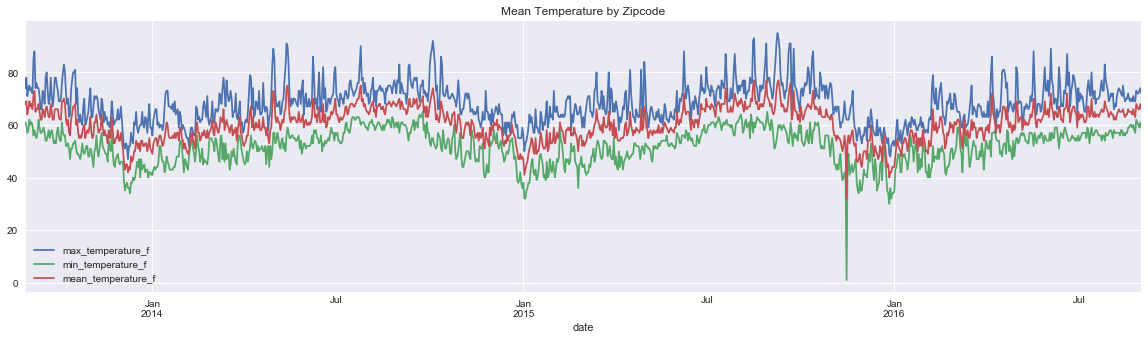

In [15]:
# plot histogram of trip duration
weather_sf[['max_temperature_f', 'min_temperature_f', 'mean_temperature_f']].plot(figsize=(20,5))
plt.title('Mean Temperature by Zipcode')
plt.xlabel='Date'
plt.ylabel='Mean Temp (F)'
plt.legend(loc='best')
plt.show()

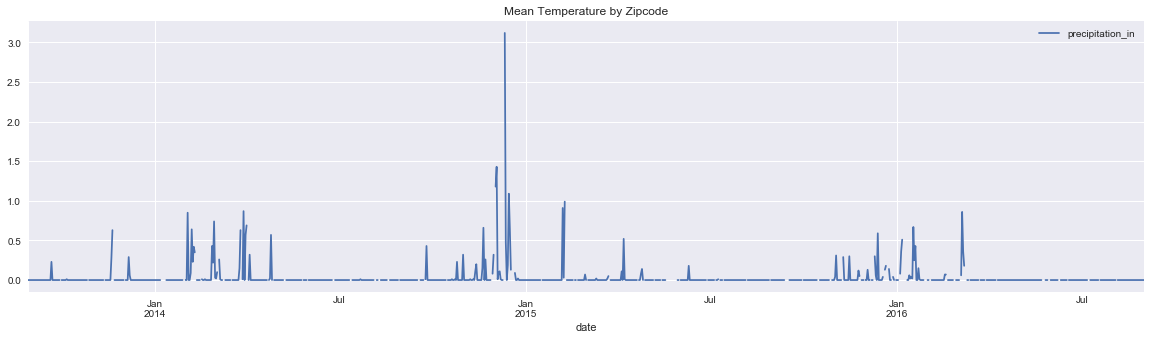

In [16]:
# plot histogram of trip duration
weather_sf['precipitation_in'].plot(figsize=(20,5))
plt.title('Mean Temperature by Zipcode')
plt.xlabel='Date'
plt.ylabel='Mean Temp (F)'
plt.legend(loc='best')
plt.show()

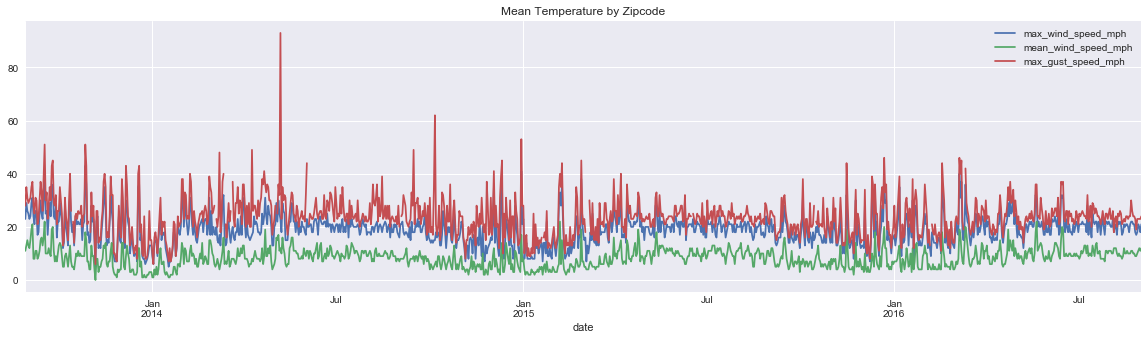

In [17]:
# plot histogram of trip duration
weather_sf[['max_wind_speed_mph','mean_wind_speed_mph','max_gust_speed_mph']].plot(figsize=(20,5))
plt.title('Mean Temperature by Zipcode')
plt.xlabel='Date'
plt.ylabel='Mean Temp (F)'
plt.legend(loc='best')
plt.show()



## Data Investigation

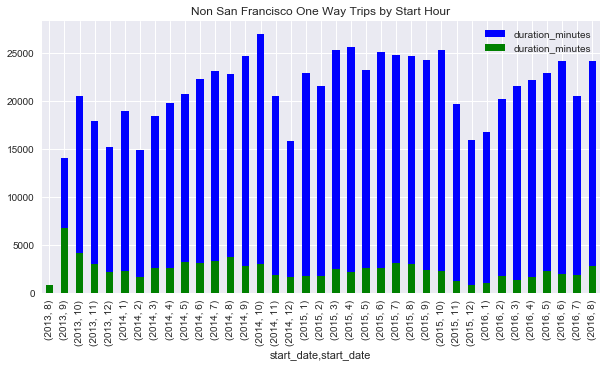

In [18]:

# prune to only 2014 data

# trips_prune = trips_sf[trips_sf['start_date'].dt.year > 2013]
# trips_prune = trips_prune[trips_prune['start_date'].dt.year < 2015]
# trips_prune = trips_prune[trips_prune['start_date'].dt.month == 1]

# trips_prune.info()

# plot trip duration by start hour
# trips_sf.groupby(['trip_date'])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(40,5))
# trips_sf.groupby([trips_sf['start_date'].dt.year, trips_sf['start_date'].dt.month])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))

# ax = one_way_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar',position=0, color='b', figsize=(10,5))
# round_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar',position=1, color='g', ax=ax)

ax = trips_sf[trips_sf['subscriber_type'] == 'Subscriber'].groupby([trips_sf['start_date'].dt.year, trips_sf['start_date'].dt.month])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))
trips_sf[trips_sf['subscriber_type'] == 'Customer'].groupby([trips_sf['start_date'].dt.year, trips_sf['start_date'].dt.month])['duration_minutes'].count().plot(kind='bar', color='g', ax=ax)

plt.title('Non San Francisco One Way Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(loc='best')
plt.show()

In [19]:
data_check = pd.DataFrame()
data_check['trips'] = trips_sf.groupby(['trip_date'])['bike_#'].count()
data_check['mean_temp'] = weather_sf['mean_temperature_f']
data_check['max_temp'] = weather_sf['max_temperature_f']
data_check['min_temp'] = weather_sf['min_temperature_f']
data_check['precipitation_in'] = weather_sf['precipitation_in']
data_check['cloud_cover'] = weather_sf['cloud_cover']

data_check = data_check[data_check['min_temp'] > 20.0]

data_check.info()


# hospital_df = clean_hospital_read_df[np.isfinite(clean_hospital_read_df['Excess Readmission Ratio'])]
rainy_days = data_check[np.isfinite(data_check['precipitation_in'])]

# prune only rainy days, precipitation_in > 0.0, and remove the super rainy outlier
rainy_days = rainy_days[rainy_days['precipitation_in'] > 0.0]

# rainy_days.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 2013-08-29 to 2016-08-31
Data columns (total 6 columns):
trips               1098 non-null int64
mean_temp           1098 non-null float64
max_temp            1098 non-null float64
min_temp            1098 non-null float64
precipitation_in    979 non-null float64
cloud_cover         1098 non-null float64
dtypes: float64(5), int64(1)
memory usage: 60.0+ KB


In [20]:
data_check.head()

,trips,mean_temp,max_temp,min_temp,precipitation_in,cloud_cover
trip_date,,,,,,
2013-08-29,609,68.0,74.0,61.0,0.0,4.0
2013-08-30,531,69.0,78.0,60.0,0.0,2.0
2013-08-31,429,64.0,71.0,57.0,0.0,4.0
2013-09-01,465,66.0,74.0,58.0,0.0,4.0
2013-09-02,486,69.0,75.0,62.0,0.0,6.0


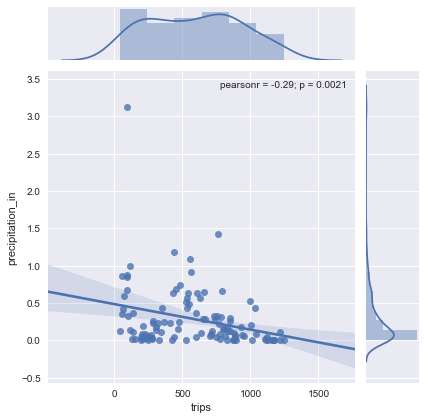

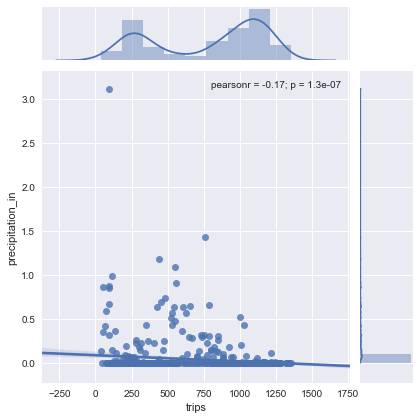

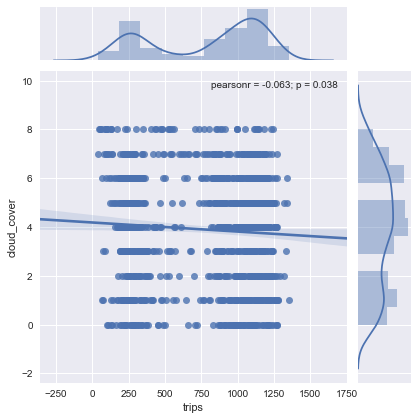

In [21]:
# plot precipitation by number of rides in that day
sns.jointplot('trips', 'precipitation_in', data=rainy_days, kind='reg')
sns.jointplot('trips', 'precipitation_in', data=data_check, kind='reg')
sns.jointplot('trips', 'cloud_cover', data=data_check, kind='reg')
plt.show()

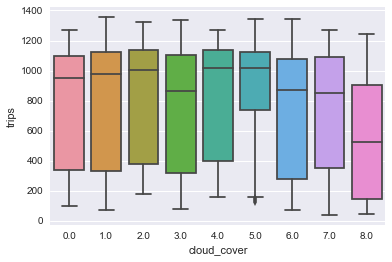

In [22]:
# plot rides by cloud cover

sns.boxplot(x='cloud_cover', y='trips', data=data_check)
plt.show()


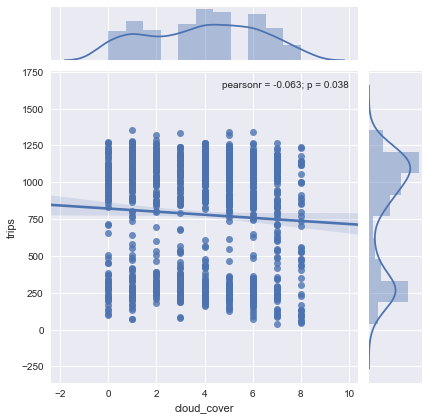

In [23]:
sns.jointplot('cloud_cover', 'trips', data=data_check, kind='reg')
plt.show()

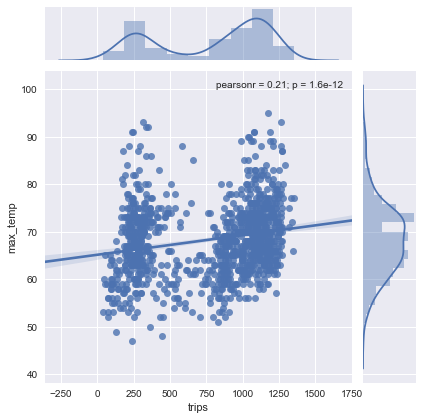

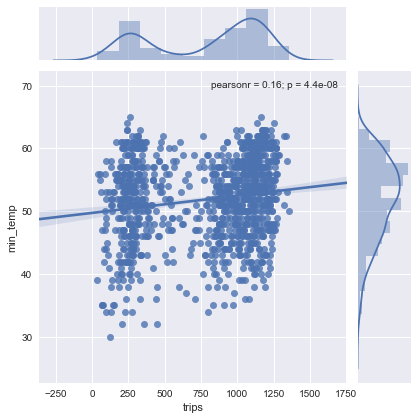

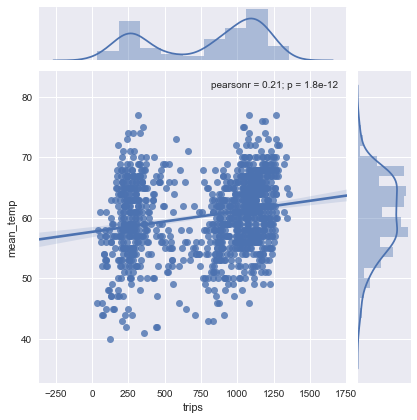

In [24]:
# plot temperature max, min, mean by number of rides in that day
# sns.jointplot('trips', 'precipitation_in', data=rainy_days, kind='reg')
sns.jointplot('trips', 'max_temp', data=data_check, kind='reg')
sns.jointplot('trips', 'min_temp', data=data_check, kind='reg')
sns.jointplot('trips', 'mean_temp', data=data_check, kind='reg')
plt.show()

In [25]:
# # trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='r', figsize=(10,5))

# data_check.groupby('min_temp')['trips'].count().plot(color='r', figsize=(10,5))
# data_check.groupby('max_temp')['trips'].count().plot(color='g')
# data_check.groupby('mean_temp')['trips'].count().plot(color='b')
# plt.show()

In [26]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 12 columns):
duration            983648 non-null int64
start_date          983648 non-null datetime64[ns]
start_terminal      983648 non-null int64
end_date            983648 non-null datetime64[ns]
end_terminal        983648 non-null int64
bike_#              983648 non-null int64
subscriber_type     983648 non-null object
zip_code            945782 non-null float64
duration_minutes    983648 non-null float64
trip_date           983648 non-null object
start_hour          983648 non-null int64
end_hour            983648 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(6), object(2)
memory usage: 97.6+ MB


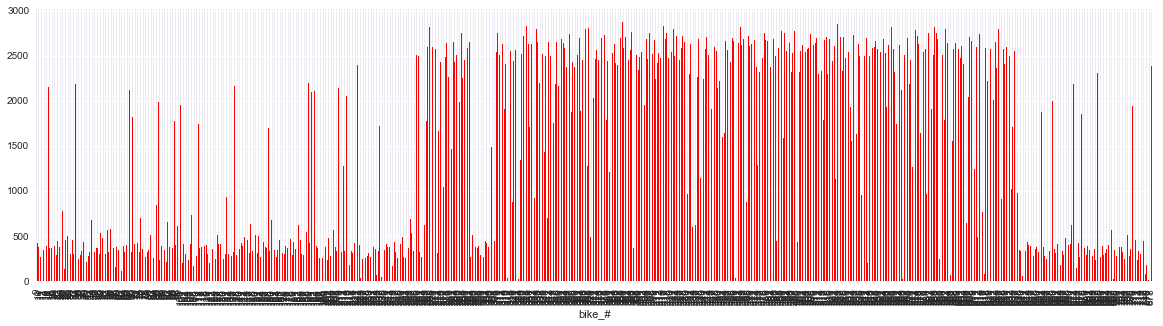

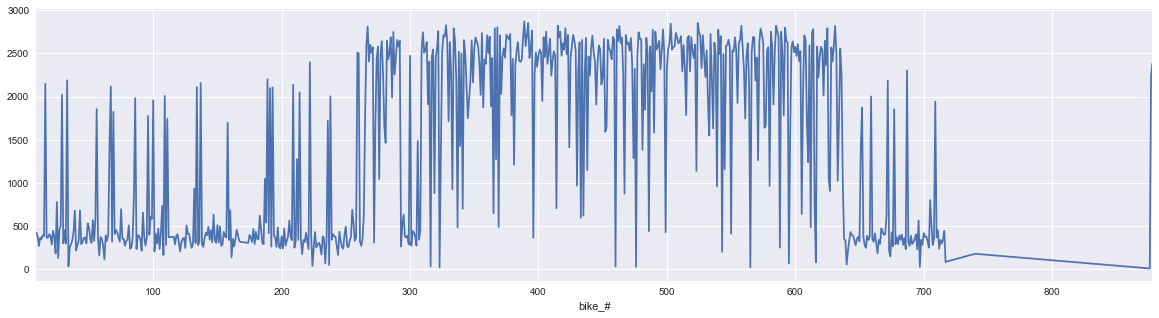

In [27]:
trip.groupby('bike_#')['start_hour'].count().plot(kind='bar', color='r', figsize=(20,5))
plt.show()

trip.groupby('bike_#')['end_hour'].count().plot(figsize=(20,5))
plt.show()